## **Fake News Classification**

In [ ]:
# Mounting to drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

cd drive/

/content/drive


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
import collections
from sklearn_pandas import DataFrameMapper
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE  

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Reading the Testing and Training Files
training_data = pd.read_csv('MyDrive/IIT/Semester4/OSNA/Project2/Bhatia_Naik_PJ2/Data/train.csv')
testing_data = pd.read_csv('MyDrive/IIT/Semester4/OSNA/Project2/Bhatia_Naik_PJ2/Data/test.csv')


In [ ]:
print("The shape of training data is", training_data.shape)
print("The shape of testing data is", testing_data.shape)

The shape of training data is (256442, 6)
The shape of testing data is (64110, 5)


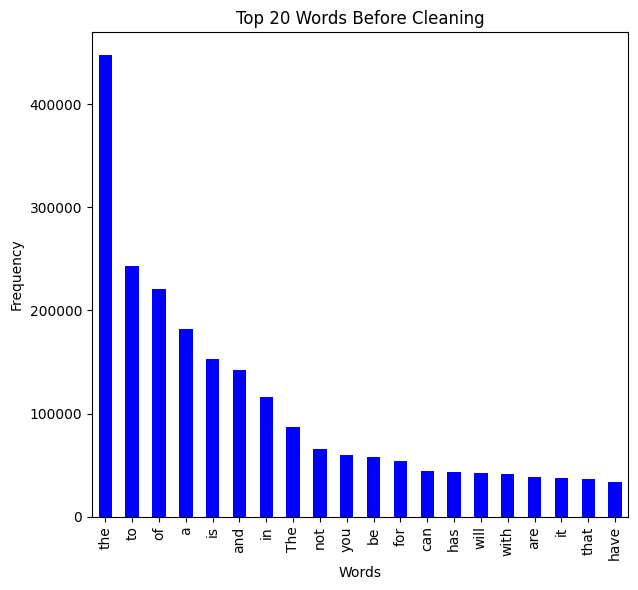

In [ ]:
# Calculate word frequencies before cleaning
word_freq_before = pd.Series(' '.join(training_data['title1_en']+" "+training_data['title2_en']).split()).value_counts()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
word_freq_before[:20].plot(kind='bar', color='blue')
plt.title('Top 20 Words Before Cleaning')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
def extract_keywords(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9 ]', '', text)
    text = re.sub("\s\s+", " ", text) 
    text= ' '.join(text.split())
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])
    return text

In [ ]:
title1_en=training_data['title1_en'].apply(extract_keywords)
title2_en = training_data['title2_en'].apply(extract_keywords)
training_data['title1_en']=title1_en
training_data['title2_en']=title2_en
    

In [ ]:
title1_en=testing_data['title1_en'].apply(extract_keywords)
title2_en = testing_data['title2_en'].apply(extract_keywords)
testing_data['title1_en']=title1_en
testing_data['title2_en']=title2_en


In [ ]:
data_per_class = Counter(training_data['label'])
print("Records as per the label feature: ")
for i, label in enumerate(data_per_class):
    print(f"{label} : {data_per_class[label]} ({data_per_class[label] / training_data.shape[0]*100:.3f})%")


Records as per the label feature: 
unrelated : 175598 (68.475)%
agreed : 74238 (28.949)%
disagreed : 6606 (2.576)%


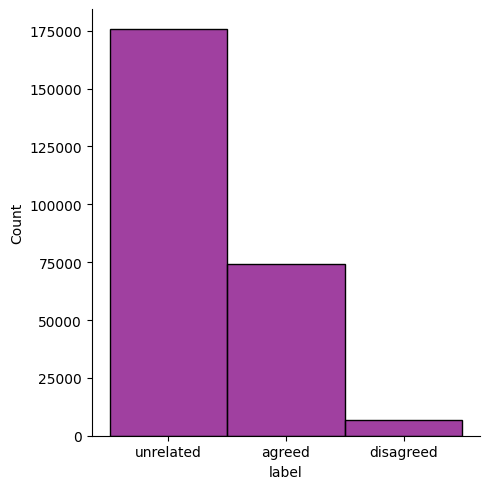

In [ ]:
sns.displot(training_data, x='label',color='purple')

In [ ]:
def merge_titles(text):
    return (text['title1_en']+" "+text['title2_en'])
training_data['merged_titles'] = training_data[['title1_en', 'title2_en']].apply(merge_titles, axis=1)
testing_data['merged_titles'] = testing_data[['title1_en', 'title2_en']].apply(merge_titles, axis=1)


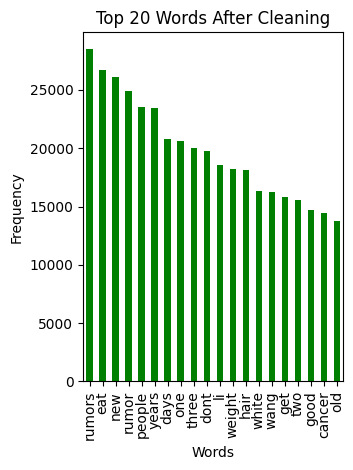

In [ ]:
# Calculate word frequencies after cleaning
word_freq_after = pd.Series(' '.join(training_data['merged_titles']).split()).value_counts()
plt.subplot(1,2,2)
word_freq_after[:20].plot(kind='bar', color='green')
plt.title('Top 20 Words After Cleaning')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
training_data_split, validation_data_split = train_test_split(training_data, test_size=0.3,stratify=training_data['label'],random_state=9)

In [ ]:
Tfidvectorizer = TfidfVectorizer(stop_words="english", strip_accents="unicode", lowercase=False, encoding='utf-8', min_df=3)
training_vectorized_data=Tfidvectorizer.fit_transform(training_data_split['merged_titles'])
validation_vectorized_data=Tfidvectorizer.transform(validation_data_split['merged_titles'])
testing_vectorized_data=Tfidvectorizer.transform(testing_data['merged_titles'])
train_labels=training_data_split['label']
validation_labels = validation_data_split['label']


In [ ]:
training_vectorized_data_before =training_vectorized_data
train_labels_before=training_data_split['label']

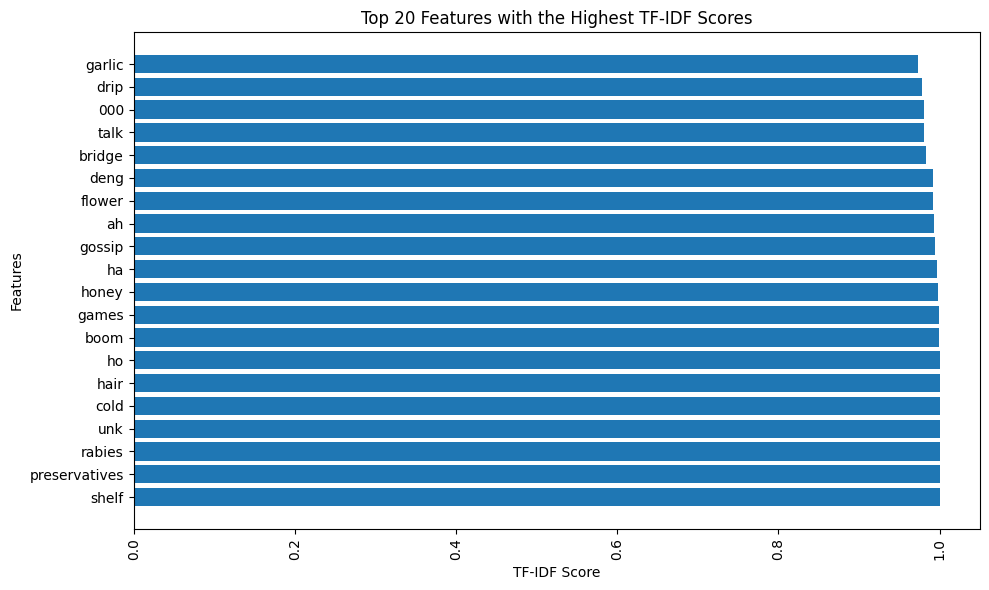

In [ ]:
feature_names = Tfidvectorizer.get_feature_names_out() 
tfidf_scores = training_vectorized_data.max(0).toarray()[0]

# Sort the features by their TF-IDF scores in descending order
sorted_indices = tfidf_scores.argsort()[::-1]
sorted_features = [feature_names[idx] for idx in sorted_indices]

# Plot the top N features with the highest TF-IDF scores
N = 20
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:N], tfidf_scores[sorted_indices][:N])
plt.xticks(rotation=90)
plt.xlabel("TF-IDF Score")
plt.ylabel("Features")
plt.title(f"Top {N} Features with the Highest TF-IDF Scores")
plt.tight_layout()
plt.show()


In [ ]:
#For Balancing the data
sampler = SMOTE()
training_vectorized_data, train_labels = sampler.fit_resample(training_vectorized_data, train_labels)

In [ ]:
data_per_class = Counter(train_labels)
print("Records after balancing dataset as per label feature: ")
for i, label in enumerate(data_per_class):
    print(f"{label} : {data_per_class[label]} ({data_per_class[label] / training_vectorized_data.shape[0]*100:.3f})%")

Records after balancing dataset as per label feature: 
unrelated : 122918 (33.333)%
agreed : 122918 (33.333)%
disagreed : 122918 (33.333)%


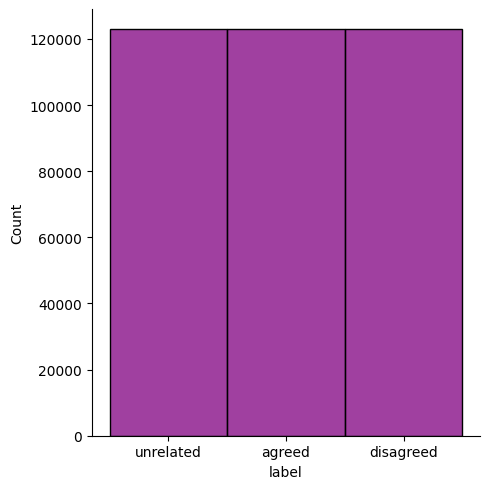

In [ ]:
sns.displot(train_labels,color='purple')

In [ ]:
#To cross-validate on finalized model
logistic_regression = LogisticRegression(solver="lbfgs",multi_class="multinomial",max_iter=5000, C=0.9)
from sklearn.model_selection import cross_val_score
# Evaluate model performance using 5-fold cross-validation on original data
scores_original = cross_val_score(logistic_regression, training_vectorized_data_before, train_labels_before, cv=5, scoring='accuracy')
print('Accuracy on original data:')
print(scores_original.mean())

# Evaluate model performance using 5-fold cross-validation on resampled data
scores_resampled = cross_val_score(logistic_regression, training_vectorized_data, train_labels, cv=5, scoring='accuracy')
print('Accuracy on resampled data:')
print(scores_resampled.mean())

Accuracy on original data:
0.795731681401021
Accuracy on resampled data:
0.854287705809907


Training time for logistic regression: 108.7260 seconds
[[110868    744  11306]
 [    85 121620   1213]
 [ 24033   7458  91427]]
Logistic Regression Accuracy Score:
0.8784040308715295


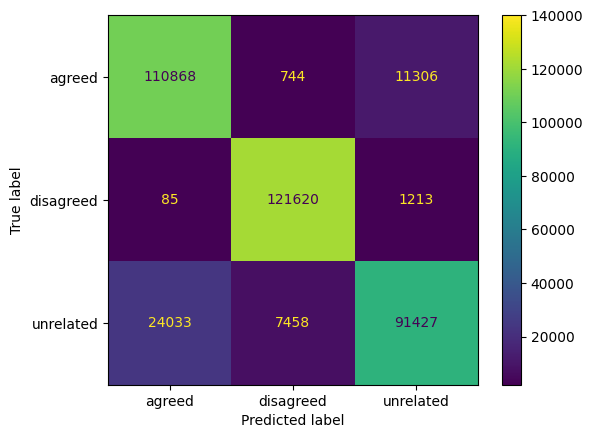

In [ ]:
#logistic Regression
import time
# Record the start time
start_time = time.time()
logistic_regression_model = LogisticRegression(solver="lbfgs",multi_class="multinomial",max_iter=5000,C=0.9).fit(training_vectorized_data, train_labels)
# Record the end time
end_time = time.time()
# Calculate the training time
training_time = end_time - start_time

# Print the training time
print("Training time for logistic regression: %.4f seconds" % training_time)

logistic_regression_model.score(training_vectorized_data, train_labels)
y_pred=logistic_regression_model.predict(training_vectorized_data)
cnf_matrix_l1_primary_dataset = metrics.confusion_matrix(train_labels, y_pred)
print(cnf_matrix_l1_primary_dataset)
print('Logistic Regression Accuracy Score:')
print(logistic_regression_model.score(training_vectorized_data, train_labels))
ConfusionMatrixDisplay.from_estimator(logistic_regression_model, training_vectorized_data, train_labels)
for im in plt.gca().get_images():                   # set clim manually within the image
    im.set_clim(vmin=2000,vmax=140000)              # set your manual range for the colorbar here
plt.show()

In [ ]:
validation_predicted_labels=logistic_regression_model.predict(validation_vectorized_data)
print('Confustion Matrix for Validation Data:')
cnf_matrix_l1_primary_dataset = metrics.confusion_matrix(validation_labels, validation_predicted_labels)
print(cnf_matrix_l1_primary_dataset)
print('Logistic Regression Accuracy Score for Validation Data:')
print(logistic_regression_model.score(validation_vectorized_data, validation_labels))
print('Classification Report for Validation Data:')
print(classification_report(validation_labels, validation_predicted_labels))


Confustion Matrix for Validation Data:
[[13414    15  8842]
 [   52   366  1564]
 [ 4782    81 47817]]
Logistic Regression Accuracy Score for Validation Data:
0.800657715154745
Classification Report for Validation Data:
              precision    recall  f1-score   support

      agreed       0.74      0.60      0.66     22271
   disagreed       0.79      0.18      0.30      1982
   unrelated       0.82      0.91      0.86     52680

    accuracy                           0.80     76933
   macro avg       0.78      0.56      0.61     76933
weighted avg       0.80      0.80      0.79     76933



In [ ]:
test_predicted_labels=logistic_regression_model.predict(testing_vectorized_data)

In [ ]:
results=pd.DataFrame({"id": testing_data["id"], "label": test_predicted_labels})

In [ ]:
results.to_csv("MyDrive/IIT/Semester4/OSNA/Project2/Bhatia_Naik_PJ2/submission.csv")

In [ ]:
results

,id,label
0,256442,unrelated
1,256443,unrelated
2,256444,unrelated
3,256445,unrelated
4,256446,unrelated
...,...,...
64105,320547,agreed
64106,320548,agreed
64107,320549,agreed
64108,320550,unrelated
